# Tasca 7 : Transformació Registre Log amb Regular expressions


L'anàlisi de registres és una funció important per al control i l'alerta, el compliment de les polítiques de seguretat, l'auditoria i el compliment normatiu, la resposta a incidents de seguretat i fins i tot les investigacions forenses. En analitzar les dades de registre, les empreses poden identificar més fàcilment les possibles amenaces i altres problemes, trobar la causa arrel i iniciar una resposta ràpida per mitigar els riscos.

- [Exercici 1](#Exercici1)  
- [Exercici 2](#Exercici2)    
- [Exercici 3](#Exercici3)  
- [Exercici 4](#Exercici4)

## Nivell 1
L'analista ha d'assegurar-se que els registres consisteixen en una gamma completa de missatges i s'interpreten segons el context. Els elements de registre han de normalitzar-se, utilitzant els mateixos termes o terminologia, per evitar confusions i proporcionar cohesió.

Com Científic de Dades se t'ha proporcionat accés als registres-Logs on queda registrada l'activitat de totes les visites a realitzades a la pàgina web de l'agència de viatges "akumenius.com".

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


import requests
import json
import re

from tqdm import tqdm, notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
file = '../data-sources/Web_access_log-akumenius.com.txt'

f = open(file, 'r')
lines = []
for i in range(30):
    lines.append(f.readline())

# print(f.readlines(356))

f.close()

### Funcions auxiliars

In [149]:
def plot_top(kind, data, x, y, top=5, others=True, **params):
    data = data[y].value_counts().reset_index()
    val_others = data[top:][y].sum()
    dades = data[:top]

    if others:
        dades = pd.concat((dades,pd.DataFrame({x:'Altres', y:val_others}, index=[top+1])), axis=0)
    
    g = kind(data=dades, x=x, y=y, **params)
    return g
    

<a id='Exercici1'></a>
### Exercici 1
Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

[format dels logs Apache](http://httpd.apache.org/docs/1.3/logs.html)

La solució proposada [aquí -stackoverflow-](https://stackoverflow.com/questions/12544510/parsing-apache-log-files) sembla un bon començament

**<font color='#FE2712'>hostname</font> 
<font color='#FC600A'>ip</font> 
<font color='#FB9902'>remote_log_name</font> 
<font color='#FCCC1A'>userid</font>** 
[<font color='#66B032'>**date timezone**</font>] 
"<font color='#347C98'>**request_method**</font>
<font color='#FF0080'>**path**</font> 
_HTTP/_<font color='#0247FE'>**request_version**</font>" 
<font color='#4424D6'>**status**</font>
<font color='#0080FF'>**length**</font> 
"<font color='#8601AF'>**referrer**" </font>
"<font color='#C21460'>**user_agent**" </font> VLOG=-

#### Exemples:
**<font color='#FE2712'>localhost</font> 
<font color='#FC600A'>127.0.0.1</font> 
<font color='#FB9902'>-</font> 
<font color='#FCCC1A'>-</font>** 
[<font color='#66B032'>**23/Feb/2014:03:10:31 +0100**</font>] 
"<font color='347C98'>**OPTIONS**</font> 
<font color='#FF0080'>**\***</font> 
_HTTP/_<font color='#0247FE'>**1.0**</font>" 
<font color='#4424D6'>**200**</font>
<font color='#0080FF'>**-**</font> 
"<font color='#8601AF'>**-**" </font>
"<font color='#C21460'>**Apache (internal dummy connection)**" </font> VLOG=-  

**<font color='#FE2712'>www\.akumenius.com</font> 
<font color='#FC600A'>66.249.76.216</font> 
<font color='#FB9902'>-</font> 
<font color='#FCCC1A'>-</font>** 
[<font color='#66B032'>**23/Feb/2014:03:10:45 +0100**</font>] 
"<font color='#347C98'>**GET**</font>
<font color='#FF0080'>**/hoteles-baratos/ofertas-hotel-Kfar-Giladi-en-Tiberias-121085b-destinos.html**</font> 
_HTTP/_<font color='#0247FE'>**1.1**</font>" 
<font color='#4424D6'>**404**</font>
<font color='#0080FF'>**3100**</font> 
"<font color='#8601AF'>**-**" </font>
"<font color='#C21460'>**Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)**" </font> VLOG=-



In [3]:
ex1 = 'localhost 127.0.0.1 - - [23/Feb/2014:03:10:31 +0100] "OPTIONS * HTTP/1.0" 200 - "-" "Apache (internal dummy connection)" VLOG=-'
ex2 = 'www.akumenius.com 66.249.76.216 - - [23/Feb/2014:03:10:45 +0100] "GET /hoteles-baratos/ofertas-hotel-Kfar-Giladi-en-Tiberias-121085b-destinos.html HTTP/1.1" 404 3100 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)" VLOG=-'


In [4]:
re.findall(r'^localhost', ex1)

['localhost']

In [5]:
regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+) - "(.*?)" "(.*?)" (.*?)'
regex2 = '^(?P<hostname>.*?) (?P<ip>[(\d\.)]+) (?P<rem_log>.*?) (?P<userid>.*?) \[(?P<date>.*?)\] "(?P<request>.*?)" (?P<status>\d+) (?P<length>.*?) "(?P<referrer>.*?)" "(?P<user_agent>.*?)" (.*?)'

# from https://stackoverflow.com/questions/40549123/apache-access-log-regex-parsing
regex3 = '(?P<hostname>.*?) (?P<ip>.*?) (?P<remote_log_name>.*?) (?P<userid>.*?) \[(?P<date>.*?)(?= ) (?P<timezone>.*?)\] "(?P<request_method>.*?) (?P<path>.*?) (?P<request_version>HTTP/.*)?" (?P<status>.*?) (?P<length>.*?) \"(?P<referrer>.*?)\" \"(?P<user_agent>.*?)\" '
regex4 = '^([\\d.]+) (\\S+) 3(\\S+) \\[([\\w:/]+\\s[+-]\\d{4})\\] \"(.+?)\" (\\d{3}) (\\d+) \"([^\"]+)\" \"(.+?)\"'

In [6]:
re.match(regex3, ex1).groups()

('localhost',
 '127.0.0.1',
 '-',
 '-',
 '23/Feb/2014:03:10:31',
 '+0100',
 'OPTIONS',
 '*',
 'HTTP/1.0',
 '200',
 '-',
 '-',
 'Apache (internal dummy connection)')

In [7]:
re.match(regex3, ex2).groups()

('www.akumenius.com',
 '66.249.76.216',
 '-',
 '-',
 '23/Feb/2014:03:10:45',
 '+0100',
 'GET',
 '/hoteles-baratos/ofertas-hotel-Kfar-Giladi-en-Tiberias-121085b-destinos.html',
 'HTTP/1.1',
 '404',
 '3100',
 '-',
 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)')

In [8]:
re.match(regex2, ex2).groups()

('www.akumenius.com',
 '66.249.76.216',
 '-',
 '-',
 '23/Feb/2014:03:10:45 +0100',
 'GET /hoteles-baratos/ofertas-hotel-Kfar-Giladi-en-Tiberias-121085b-destinos.html HTTP/1.1',
 '404',
 '3100',
 '-',
 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
 '')

In [9]:
file = '../data-sources/Web_access_log-akumenius.com.txt'

# f = open(file, 'r')
parsed_lines = []
with open(file, 'r') as lines:
    try:
        while True:
            current = next(lines)
#             print(current)
            parsed_lines.append(re.match(regex2,current).groups())
    except StopIteration:
        print('Acabada la càrrega')

# print(f.readlines(356))

# f.close()
df = pd.DataFrame(parsed_lines)

Acabada la càrrega


In [10]:
df.columns = ['hostname','ip','rem_log_name','userid','date',
              'request','status','length','referrer','user_agent', 'vlog']
df.shape

(261873, 11)

In [11]:
df.drop_duplicates(inplace=True)
df.shape

(257310, 11)

In [12]:
df[['request_method','path','request_version']] = df.request.str.extract("(?P<request_method>.*?) (?P<path>.*?) (?P<request_version>HTTP/.*)?", )

In [13]:
df['path_split'] = df.path.str.split('/')

In [14]:

df['data'] = pd.to_datetime(df.date, format='%d/%b/%Y:%X %z')

In [15]:
df.ip.unique()[:20]

array(['127.0.0.1', '66.249.76.216', '5.255.253.53', '157.55.35.112',
       '193.111.141.116', '5.10.83.71', '180.76.5.223', '180.76.6.148',
       '180.76.5.188', '180.76.6.135', '180.76.6.44', '180.76.5.172',
       '180.76.5.18', '157.56.92.174', '74.86.158.107', '180.76.6.136',
       '5.10.83.87', '5.10.83.21', '5.10.83.31', '180.76.5.64'],
      dtype=object)

### GEO IP 

Busquem la geolocalització de les IP

res = requests.get('https://freegeoip.app/json/66.249.76.216')



In [23]:
res = requests.get('https://freegeoip.app/json/83.45.86.81')
res.json()

{'ip': '83.45.86.81',
 'country_code': 'ES',
 'country_name': 'Spain',
 'region_code': 'CT',
 'region_name': 'Catalonia',
 'city': 'Olot',
 'zip_code': '17800',
 'time_zone': 'Europe/Madrid',
 'latitude': 42.181,
 'longitude': 2.4901,
 'metro_code': 0}

#### freegeoip

In [16]:
# resultats = []

# for ip in tqdm(df.ip.unique()):
#     resultats.append(requests.get(f'https://freegeoip.app/json/{ip}').json())
    
# localitzacions = pd.DataFrame(resultats)

In [17]:
localitzacions = pd.read_pickle('../data/loc_geoip.pickle')

In [18]:
# localitzacions.to_pickle('../data/loc_geoip.pickle')

In [19]:
localitzacions.head()

,ip,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,127.0.0.1,,,,,,,,0.0000,0.0000,0
1,66.249.76.216,US,United States,,,,,America/Chicago,37.7510,-97.8220,0
2,5.255.253.53,RU,Russia,MOW,Moscow,Moscow,125009,Europe/Moscow,55.7527,37.6172,0
3,157.55.35.112,US,United States,WA,Washington,,,America/Los_Angeles,47.6032,-122.3412,0
4,193.111.141.116,DE,Germany,NW,North Rhine-Westphalia,Düsseldorf,40472,Europe/Berlin,51.2705,6.8144,0


In [148]:
localitzacions.isna().sum(axis=0)

ip              0
country_code    0
country_name    0
region_code     0
region_name     0
city            0
zip_code        0
time_zone       0
latitude        0
longitude       0
metro_code      0
dtype: int64

#### ip2geotools

In [142]:
from ip2geotools.databases.noncommercial import DbIpCity

ips = df.ip.unique().tolist()
ips.remove('127.0.0.1')
print(ips[:10])
resultats = []
processed = list(pd.read_pickle('../tmp/tmp_processed.pickle').to_dict()[0].values())

['66.249.76.216', '5.255.253.53', '157.55.35.112', '193.111.141.116', '5.10.83.71', '180.76.5.223', '180.76.6.148', '180.76.5.188', '180.76.6.135', '180.76.6.44']


In [159]:
not_proc = [ip for ip in ips if ip not in processed]

for ip in tqdm(not_proc):
    resultats.append(DbIpCity.get(ip, api_key='free').to_json())
    processed.append(ip)

  0%|          | 0/920 [00:00<?, ?it/s]


InvalidRequestError: 

In [157]:
len(processed)

2000

In [174]:
# GEOLITE
# estic bloquejat en el servei
# resultats = []

# for ip in tqdm(df.ip.unique()):
#     resultats.append(requests.get(f'http://www.geoplugin.net/json.gp?ip={ip}').json())
    
# localitzacions2 = pd.DataFrame(resultats)

In [158]:
pd.DataFrame(processed).to_pickle('../tmp/tmp_processed.pickle')

### Localitzacions

In [36]:
localitzacions.head()

,ip,country_code,country_name,region_code,region_name,city,zip_code,time_zone,latitude,longitude,metro_code
0,127.0.0.1,,,,,,,,0.0000,0.0000,0
1,66.249.76.216,US,United States,,,,,America/Chicago,37.7510,-97.8220,0
2,5.255.253.53,RU,Russia,MOW,Moscow,Moscow,125009,Europe/Moscow,55.7527,37.6172,0
3,157.55.35.112,US,United States,WA,Washington,,,America/Los_Angeles,47.6032,-122.3412,0
4,193.111.141.116,DE,Germany,NW,North Rhine-Westphalia,Düsseldorf,40472,Europe/Berlin,51.2705,6.8144,0


In [37]:
localitzacions.country_code.nunique()

64

In [38]:
localitzacions.shape

(2921, 11)

<AxesSubplot:xlabel='index', ylabel='country_code'>

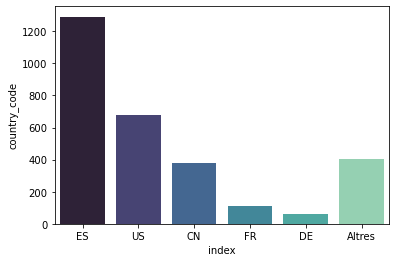

In [152]:
plot_top(sns.barplot, data=localitzacions, x='index', y='country_code', palette='mako')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

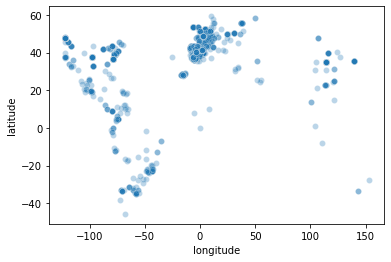

In [156]:
sns.scatterplot(data=localitzacions, x='longitude', y='latitude', alpha=0.3)

<AxesSubplot:xlabel='index', ylabel='country_code'>

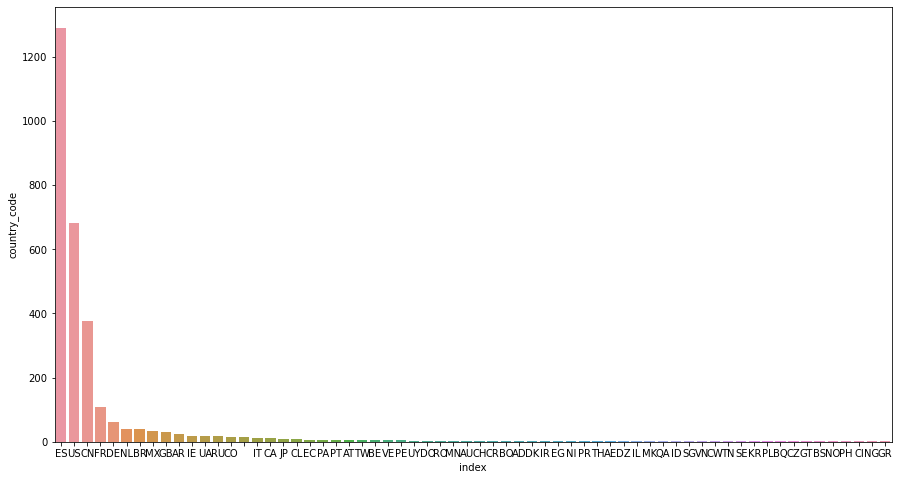

In [39]:
plt.figure(figsize=(15,8))
sns.barplot(data=localitzacions.country_code.value_counts().reset_index(), x='index',y='country_code')

Text(0.5, 1.0, 'Top 5 Països')

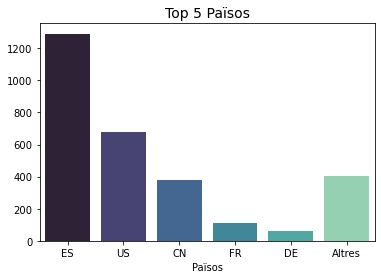

In [40]:

    
g = plot_top(sns.barplot, data=localitzacions, x='index', y='country_code', 
            palette='mako')
g.set_xlabel('Països',)
g.set_ylabel('')
g.set_title('Top 5 Països', size=14)

In [171]:
# # check for duplicated
# mask = (df.request_method != 'OPTIONS')
# df[mask][df[mask][['hostname','ip','rem_log_name','userid','data','request','status','length','referrer','user_agent', 'vlog']].duplicated()]

### USER AGENT Parsing

#### ua_parser

In [42]:
from ua_parser import user_agent_parser

ua_parser = pd.json_normalize(df.user_agent.apply(lambda x: user_agent_parser.Parse(x)), sep='_')

In [43]:
ua_parser.user_agent_family.value_counts().reset_index()

,index,user_agent_family
0,Googlebot,51739
1,Chrome,39075
2,Firefox,33947
3,IE,32487
4,Android,20848
...,...,...
88,Galeon,1
89,PaperLiBot,1
90,Xenu Link Sleuth,1
91,Firefox Beta,1


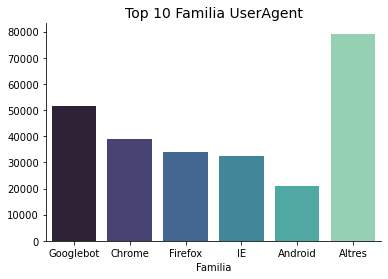

In [44]:

g = plot_top(sns.barplot, ua_parser, x='index',y='user_agent_family', top=5, palette='mako')
g.set_xlabel('Familia',)
g.set_ylabel('')
g.set_title('Top 10 Familia UserAgent', size=14)
sns.despine()


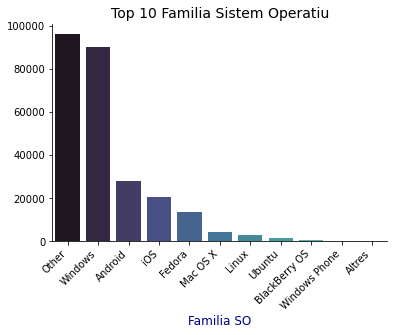

In [45]:
g = plot_top(sns.barplot, ua_parser, x='index',y='os_family', top=10, palette='mako')
g.set_xlabel('Familia SO' , fontdict={'fontsize':12, 'color':'darkblue'})
g.set_ylabel('')
g.set_title('Top 10 Familia Sistem Operatiu', size=14)

# plt.xticks(rotation=45, horizontalalignment='right')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.despine()



Text(0.5, 1.0, 'Familia UA per a SO (Other). Bots?')

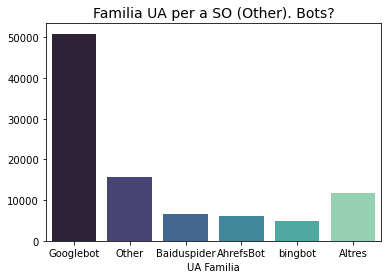

In [135]:
g = plot_top(sns.barplot, ua_parser[ua_parser.os_family == 'Other'], x='index', y='user_agent_family', palette='mako')
g.set_xlabel('UA Familia' )
g.set_ylabel('')
g.set_title('Familia UA per a SO (Other). Bots?', size=14)

In [47]:
ua_parser.head()

,string,user_agent_family,user_agent_major,user_agent_minor,user_agent_patch,os_family,os_major,os_minor,os_patch,os_patch_minor,device_family,device_brand,device_model
0,Apache (internal dummy connection),Other,None,None,None,Other,None,None,None,None,Other,None,None
1,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,2,1,None,Other,None,None,None,None,Spider,Spider,Desktop
2,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,2,1,None,Other,None,None,None,None,Spider,Spider,Desktop
3,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,2,1,None,Other,None,None,None,None,Spider,Spider,Desktop
4,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,Googlebot,2,1,None,Other,None,None,None,None,Spider,Spider,Desktop


In [48]:
user_agent_parser.Parse(df.user_agent[135546], )

{'user_agent': {'family': 'Android', 'major': '4', 'minor': '1', 'patch': '2'},
 'os': {'family': 'Android',
  'major': '4',
  'minor': '1',
  'patch': '2',
  'patch_minor': None},
 'device': {'family': 'Samsung GT-I8190N',
  'brand': 'Samsung',
  'model': 'GT-I8190N'},
 'string': 'Mozilla/5.0 (Linux; U; Android 4.1.2; es-es; SAMSUNG GT-I8190N/I8190NXXAMG6 Build/JZO54K) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30'}

#### DeviceDetector

In [49]:
from device_detector import DeviceDetector

In [50]:
DeviceDetector(df.user_agent[135522]).parse().all_details

{'bot': {},
 'normalized': '',
 'os': {'name': 'Windows',
  'version': 'Vista',
  'type': 'os',
  'short_name': 'WIN',
  'family': 'Windows',
  'platform': ''},
 'client': {'name': 'Internet Explorer',
  'version': '7.0',
  'engine': {'default': 'Trident'},
  'type': 'browser',
  'short_name': 'IE',
  'app_id': ''}}

In [51]:
DeviceDetector(df.user_agent[135522]).parse()

DeviceDetector(Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0))

In [52]:
(df.user_agent[133120:133166].apply(lambda x: DeviceDetector(x).parse().all_details)).values[1]

{'bot': {'name': 'Googlebot',
  'category': 'Search bot',
  'url': 'http://www.google.com/bot.html',
  'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'},
  'type': 'bot'}}

In [53]:
df.user_agent[133120:133166].apply(lambda x: DeviceDetector(x).parse().all_details)

135513    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135514    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135515    {'bot': {'name': 'aHrefs Bot', 'category': 'Cr...
135516    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135517    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135518    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135519    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135520    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135521    {'bot': {'name': 'aHrefs Bot', 'category': 'Cr...
135522    {'bot': {}, 'normalized': '', 'os': {'name': '...
135523    {'bot': {'name': 'aHrefs Bot', 'category': 'Cr...
135524    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135525    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135526    {'bot': {'name': 'BingBot', 'category': 'Searc...
135527    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135528    {'bot': {'name': 'Googlebot', 'category': 'Sea...
135529    {'bot': {'name': 'Googlebot', 

In [229]:
for i in range(135513,135540):
    print(DeviceDetector(df.loc[i].user_agent).parse().all_details)

{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html', 'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'}, 'type': 'bot'}}
{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html', 'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'}, 'type': 'bot'}}
{'bot': {'name': 'aHrefs Bot', 'category': 'Crawler', 'url': 'http://ahrefs.com/robot', 'producer': {'name': 'Ahrefs Pte Ltd', 'url': 'http://ahrefs.com/robot'}, 'type': 'bot'}}
{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html', 'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'}, 'type': 'bot'}}
{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html', 'producer': {'name': 'Google Inc.', 'url': 'http://www.google.com'}, 'type': 'bot'}}
{'bot': {'name': 'Googlebot', 'category': 'Search bot', 'url': 'http://www.google.com/bot.html

In [54]:
from device_detector import DeviceDetector

ua = 'Mozilla/5.0 (Linux; Android 4.3; C5502 Build/10.4.1.B.0.101) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.136 Mobile Safari/537.36'

# Parse UA string and load data to dict of 'os', 'client', 'device' keys
device = DeviceDetector(ua).parse()

# Use helper methods to extract data by attribute

device.is_bot()      # >>> False

device.os_name()     # >>> Android
device.os_version()  # >>> 4.3
device.engine()      # >>> WebKit

device.device_brand_name()  # >>> Sony
device.device_brand()       # >>> SO
device.device_model()       # >>> Xperia ZR
device.device_type()        # >>> smartphone

# For much faster performance, skip Bot and Device Hardware Detection
# and extract get OS / App details only.
from device_detector import SoftwareDetector

ua = 'Mozilla/5.0 (Linux; Android 6.0; 4Good Light A103 Build/MRA58K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.83 Mobile Safari/537.36'
device = SoftwareDetector(ua).parse()

device.client_name()        # >>> Chrome Mobile
device.client_short_name()  # >>> CM
device.client_type()        # >>> browser
device.client_version()     # >>> 58.0.3029.83

device.os_name()     # >>> Android
device.os_version()  # >>> 6.0
device.engine()      # >>> WebKit

device.device_brand_name()  # >>> ''
device.device_brand()       # >>> ''
device.device_model()       # >>> ''
device.device_type()        # >>> ''

# Many mobile browser UA strings contain the app info of the APP that's using the browser 
ua = 'Mozilla/5.0 (iPhone; CPU iPhone OS 12_1_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/16D57 EtsyInc/5.22 rv:52200.62.0'
device = DeviceDetector(ua).parse()

device.secondary_client_name()     # >>> EtsyInc
device.secondary_client_type()     # >>> generic
device.secondary_client_version()  # >>> 5.22

'5.22'

### Date 

In [74]:
df.reset_index().set_index('data')

,date,hostname,ip,rem_log_name,userid,request,status,length,referrer,user_agent,vlog,request_method,path,request_version,path_split
data,,,,,,,,,,,,,,,
2014-02-23 03:10:31+01:00,23/Feb/2014:03:10:31 +0100,localhost,127.0.0.1,-,-,OPTIONS * HTTP/1.0,200,-,-,Apache (internal dummy connection),,OPTIONS,*,HTTP/1.0,[*]
2014-02-23 03:10:31+01:00,23/Feb/2014:03:10:31 +0100,www.akumenius.com,66.249.76.216,-,-,GET /hoteles-baratos/ofertas-hotel-Club-&-Hote...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Club-&-Hotel-Le...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Club-&-Hotel..."
2014-02-23 03:10:33+01:00,23/Feb/2014:03:10:33 +0100,www.akumenius.com,66.249.76.216,-,-,GET /hoteles-baratos/ofertas-hotel-Metropolis-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Metropolis-Hote...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Metropolis-H..."
2014-02-23 03:10:35+01:00,23/Feb/2014:03:10:35 +0100,www.akumenius.com,66.249.76.216,-,-,GET /hoteles-baratos/ofertas-hotel-Faena-Hotel...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Faena-Hotel-Bue...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Faena-Hotel-..."
2014-02-23 03:10:38+01:00,23/Feb/2014:03:10:38 +0100,www.akumenius.com,66.249.76.216,-,-,GET /hoteles-baratos/ofertas-hotel-Kensington-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Kensington-Town...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Kensington-T..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-02 03:05:34+01:00,02/Mar/2014:03:05:34 +0100,www.akumenius.com,5.255.253.53,-,-,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"
2014-03-02 03:05:35+01:00,02/Mar/2014:03:05:35 +0100,akumenius.es,5.255.253.53,-,-,GET / HTTP/1.1,301,304,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"
2014-03-02 03:05:39+01:00,02/Mar/2014:03:05:39 +0100,www.akumenius.com,5.255.253.53,-,-,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]"


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257310 entries, 23/Feb/2014:03:10:31 +0100 to 02/Mar/2014:03:10:18 +0100
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype                               
---  ------           --------------   -----                               
 0   hostname         257310 non-null  object                              
 1   ip               257310 non-null  object                              
 2   rem_log_name     257310 non-null  object                              
 3   userid           257310 non-null  object                              
 4   request          257310 non-null  object                              
 5   status           257310 non-null  object                              
 6   length           257310 non-null  object                              
 7   referrer         257310 non-null  object                              
 8   user_agent       257310 non-null  object                              
 9   vlog    

In [105]:
df.reset_index().set_index('data',inplace=True)

In [122]:
df.index = pd.DatetimeIndex(df.data.dt.strftime('%Y-%m-%d %H:%M:%S'))

In [123]:
df

,hostname,ip,rem_log_name,userid,request,status,length,referrer,user_agent,vlog,request_method,path,request_version,path_split,data
data,,,,,,,,,,,,,,,
2014-02-23 03:10:31,localhost,127.0.0.1,-,-,OPTIONS * HTTP/1.0,200,-,-,Apache (internal dummy connection),,OPTIONS,*,HTTP/1.0,[*],2014-02-23 03:10:31+01:00
2014-02-23 03:10:31,www.akumenius.com,66.249.76.216,-,-,GET /hoteles-baratos/ofertas-hotel-Club-&-Hote...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Club-&-Hotel-Le...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Club-&-Hotel...",2014-02-23 03:10:31+01:00
2014-02-23 03:10:33,www.akumenius.com,66.249.76.216,-,-,GET /hoteles-baratos/ofertas-hotel-Metropolis-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Metropolis-Hote...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Metropolis-H...",2014-02-23 03:10:33+01:00
2014-02-23 03:10:35,www.akumenius.com,66.249.76.216,-,-,GET /hoteles-baratos/ofertas-hotel-Faena-Hotel...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Faena-Hotel-Bue...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Faena-Hotel-...",2014-02-23 03:10:35+01:00
2014-02-23 03:10:38,www.akumenius.com,66.249.76.216,-,-,GET /hoteles-baratos/ofertas-hotel-Kensington-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Kensington-Town...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Kensington-T...",2014-02-23 03:10:38+01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-02 03:05:34,www.akumenius.com,5.255.253.53,-,-,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]",2014-03-02 03:05:34+01:00
2014-03-02 03:05:35,akumenius.es,5.255.253.53,-,-,GET / HTTP/1.1,301,304,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]",2014-03-02 03:05:35+01:00
2014-03-02 03:05:39,www.akumenius.com,5.255.253.53,-,-,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]",2014-03-02 03:05:39+01:00


In [124]:
df.groupby([pd.Grouper(freq='D'),'status']).count()

hostname     ip  rem_log_name  userid  request  length  \
data       status                                                           
2014-02-23 200        33762  33762         33762   33762    33762   33762   
           206            9      9             9       9        9       9   
           301           80     80            80      80       80      80   
           304          330    330           330     330      330     330   
           400            1      1             1       1        1       1   
...                     ...    ...           ...     ...      ...     ...   
2014-03-02 200         1305   1305          1305    1305     1305    1305   
           206            3      3             3       3        3       3   
           301           12     12            12      12       12      12   
           304           34     34            34      34       34      34   
           403            6      6             6       6        6       6   

                   referrer  user_agent   vlog  request_method   path  \
data       status                                                       
2014-02-23 200        33762       33762  33762           33762  33762   
           206            9           9      9               9      9   
           301           80          80     80              80     80   
           304          330         330    330             330    330   
           400            1           1      1               1      1   
...                     ...         ...    ...             ...    ...   
2014-03-02 200         1305        1305   1305            1305   1305   
           206            3           3      3               3      3   
           301           12          12     12              12     12   
           304           34          34     34              34     34   
           403            6           6      6               6      6   

                   request_version  path_split   data  
data       status                                      
2014-02-23 200               33762       33762  33762  
           206                   9           9      9  
           301                  80          80     80  
           304                 330         330    330  
           400                   1           1      1  
...                            ...         ...    ...  
2014-03-02 200                1305        1305   1305  
           206                   3           3      3  
           301                  12          12     12  
           304                  34          34     34  
           403                   6           6      6  

[79 rows x 14 columns]

In [129]:
day_group = pd.Grouper(freq='D')

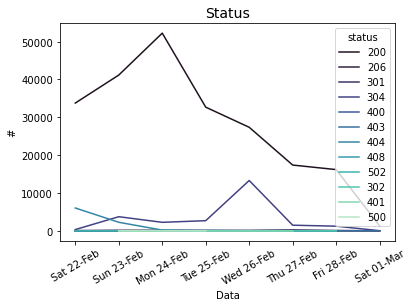

In [56]:
df.index = df.data
g = sns.lineplot(data=df.groupby([day_group,'status'])['ip'].count().reset_index(), x='data',y='ip', hue='status',
                palette='mako')

date_form = DateFormatter("%a %d-%b")
g.xaxis.set_major_formatter(date_form)
# g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel('Data',)
g.set_ylabel('#')
g.set_title('Status', size=14)
ax = plt.xticks(rotation=30)

### Request methods

In [134]:
df.request_method.value_counts().reset_index()

,index,request_method
0,GET,228776
1,OPTIONS,13868
2,POST,12847
3,HEAD,1787


Text(0.5, 1.0, 'Top 5 Mètodes Request')

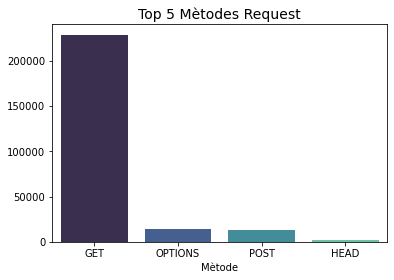

In [140]:
df.request_method.value_counts()
g = plot_top(sns.barplot, data=df, x='index',y='request_method', top=4, others=False,
            palette='mako')
g.set_xlabel('Mètode',)
g.set_ylabel('')
g.set_title('Top 5 Mètodes Request', size=14)


Text(0.5, 1.0, 'Top 5 Mètodes Request')

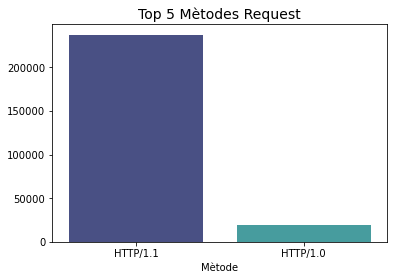

In [141]:
df.request_method.value_counts()
g = plot_top(sns.barplot, data=df, x='index',y='request_version', top=4, others=False,
            palette='mako')
g.set_xlabel('Mètode',)
g.set_ylabel('')
g.set_title('Top 5 Mètodes Request', size=14)


### Path splitting

In [58]:
# fa un split del path... i genera bastantes columnes... haurem de mirar quines... i per què genera nan i None
df.path.str.split('/', expand=True).rename(columns={i: 'col_' + str(i) for i in range(22)})['col_7'].value_counts()

buscadores                                                                   15963
blocks                                                                        7403
escapadas                                                                     4155
images                                                                        2341
boto_home_reserva.png                                                         1750
                                                                             ...  
fotoEscapadas.JPG                                                                1
place.png                                                                        1
ga.js?_=1393265663555                                                            1
2)));%7Delse%7BcenteredY%20=%20window.screenY%20+%20(((window.outerHeight        1
lupa.png                                                                         1
Name: col_7, Length: 123, dtype: int64

In [59]:
df[df.path.isna()]

,hostname,ip,rem_log_name,userid,date,request,status,length,referrer,user_agent,vlog,request_method,path,request_version,path_split,data
data,,,,,,,,,,,,,,,,
2014-02-23 14:14:41+01:00,localhost,220.181.108.108,-,-,23/Feb/2014:14:14:41 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-23 14:14:41+01:00
2014-02-23 16:42:58+01:00,localhost,69.61.47.114,-,-,23/Feb/2014:16:42:58 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-23 16:42:58+01:00
2014-02-23 19:21:43+01:00,localhost,220.181.108.79,-,-,23/Feb/2014:19:21:43 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-23 19:21:43+01:00
2014-02-24 08:48:59+01:00,localhost,188.87.251.64,-,-,24/Feb/2014:08:48:59 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-24 08:48:59+01:00
2014-02-24 10:23:25+01:00,localhost,180.76.5.214,-,-,24/Feb/2014:10:23:25 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-24 10:23:25+01:00
2014-02-24 13:08:00+01:00,localhost,62.175.136.122,-,-,24/Feb/2014:13:08:00 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-24 13:08:00+01:00
2014-02-24 13:08:01+01:00,localhost,62.175.136.122,-,-,24/Feb/2014:13:08:01 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-24 13:08:01+01:00
2014-02-24 13:08:02+01:00,localhost,62.175.136.122,-,-,24/Feb/2014:13:08:02 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-24 13:08:02+01:00
2014-02-24 13:28:49+01:00,localhost,87.111.221.104,-,-,24/Feb/2014:13:28:49 +0100,-,408,-,-,-,,NaN,NaN,NaN,NaN,2014-02-24 13:28:49+01:00


<AxesSubplot:xlabel='status', ylabel='count'>

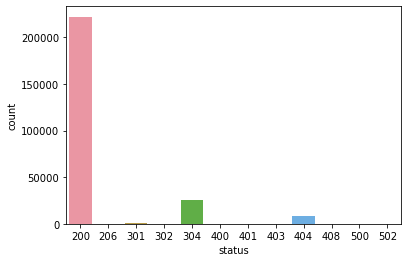

In [214]:
sns.countplot(df.status.sort_values(), )

<AxesSubplot:xlabel='index', ylabel='status'>

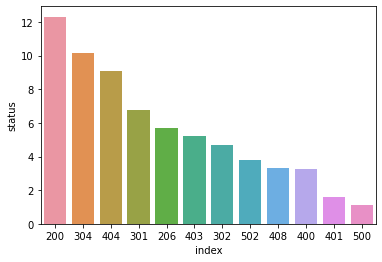

In [60]:
sns.barplot(data=np.log(df.status.value_counts()).reset_index(), x='index',y='status')

In [61]:
df.tail(40)

,hostname,ip,rem_log_name,userid,date,request,status,length,referrer,user_agent,vlog,request_method,path,request_version,path_split,data
data,,,,,,,,,,,,,,,,
2014-03-02 02:48:09+01:00,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:09 +0100,GET / HTTP/1.1,200,7528,http://www.akumenius.com/chollos,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/,HTTP/1.1,"[, ]",2014-03-02 02:48:09+01:00
2014-03-02 02:48:10+01:00,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:10 +0100,GET / HTTP/1.1,200,7528,http://www.akumenius.com/chollos,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/,HTTP/1.1,"[, ]",2014-03-02 02:48:10+01:00
2014-03-02 02:48:13+01:00,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:13 +0100,GET /chollos HTTP/1.1,200,7948,http://www.akumenius.com/escapadas,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/chollos,HTTP/1.1,"[, chollos]",2014-03-02 02:48:13+01:00
2014-03-02 02:48:14+01:00,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:14 +0100,GET /chollos HTTP/1.1,200,7948,http://www.akumenius.com/escapadas,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/chollos,HTTP/1.1,"[, chollos]",2014-03-02 02:48:14+01:00
2014-03-02 02:48:14+01:00,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:14 +0100,GET /favicon.ico HTTP/1.1,200,3175,-,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/favicon.ico,HTTP/1.1,"[, favicon.ico]",2014-03-02 02:48:14+01:00
2014-03-02 02:48:14+01:00,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:14 +0100,GET /escapadas HTTP/1.1,200,9547,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/escapadas,HTTP/1.1,"[, escapadas]",2014-03-02 02:48:14+01:00
2014-03-02 02:48:15+01:00,www.akumenius.com,83.45.25.198,-,-,02/Mar/2014:02:48:15 +0100,GET /favicon.ico HTTP/1.1,200,3175,-,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) G...,,GET,/favicon.ico,HTTP/1.1,"[, favicon.ico]",2014-03-02 02:48:15+01:00
2014-03-02 02:48:51+01:00,www.akumenius.com,66.249.76.216,-,-,02/Mar/2014:02:48:51 +0100,GET /destinos-caracteristicas/hoteles-baratos-...,200,6432,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/destinos-caracteristicas/hoteles-baratos-en-E...,HTTP/1.1,"[, destinos-caracteristicas, hoteles-baratos-e...",2014-03-02 02:48:51+01:00
2014-03-02 02:50:01+01:00,www.akumenius.com,176.31.255.177,-,-,02/Mar/2014:02:50:01 +0100,GET /hotels-consulted-update HTTP/1.0,200,-,-,Wget/1.12 (linux-gnu),,GET,/hotels-consulted-update,HTTP/1.0,"[, hotels-consulted-update]",2014-03-02 02:50:01+01:00


In [62]:
df.user_agent.str.extract('(?P<browser>.*?)[\s+]\((?P<other_info>.*?)\)').browser.unique()

array(['Apache', 'Mozilla/5.0', 'Mozilla/4.0', 'msnbot-media/1.1',
       'Wget/1.12', 'ia_archiver', 'DoCoMo/2.0 N905i(c100;TB;W24H16)',
       'Mozil178.33.117.128, Mozilla/5.0',
       'SAMSUNG-SGH-E250/1.0 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Browser/6.2.3.3.c.1.101',
       nan, 'facebookexternalhit/1.1', 'msnbot/2.0b', 'Baiduspider-image',
       'Dalvik/1.6.0', 'Curl/PHP 5.4.16', 'Opera/9.00',
       'LG-E430/Mozilla/5.0', 'Opera/8.00', 'Opera/9.80', 'Mozilla/6.0',
       'AdsBot-Google-Mobile', 'AdsBot-Google', 'Opera/7.54',
       'Mozilla/1.22', 'Google-HTTP-Java-Client/1.17.0-rc',
       'rogerbot/1.0', 'Mozilla/3.0', 'Wget/1.10.2', 'Mozilla/4.7',
       'Mozilla/4.79 [en]', "'Mozilla/5.0", 'LG-E460/Mozilla/5.0',
       'Apache-HttpClient/UNAVAILABLE', 'Apache-HttpClient/4.3',
       'Mozilla/2.0', 'Mozilla/5.0 Galeon/1.0.2'], dtype=object)

In [63]:
df.user_agent.str.extract('(?P<browser>.*?)[\s+]\((?P<other_info>.*?)\)').other_info.str.extract(';(?P<client>.*?);').client.unique()

array([nan, ' Googlebot/2.1', ' YandexBot/3.0', ' bingbot/2.0',
       ' Linux i686', ' AhrefsBot/5.0', ' Baiduspider/2.0',
       ' UptimeRobot/2.0', ' WOW64', ' spbot/4.0.7', ' MSIE 6.0',
       ' MSIE 7.0', ' Googlebot-Mobile/2.1', ' Ezooms/1.0', ' U',
       ' MJ12bot/v1.4.4', ' MSIE 8.0', ' MSIE 5.5', ' YandexImages/3.0',
       ' Android 4.1.2', ' Android 4.3', ' MSIE 10.0', ' BLEXBot/1.0',
       ' MSIE 9.0', ' EasouSpider', ' Win64', ' Trident/7.0', 'U',
       ' Android 4.2.2', ' Ubuntu', ' MSIE 5.01', ' CareerBot/1.1',
       ' Tablet', ' URLAppendBot/1.0', ' Exabot/3.0', ' MSIE 5.0',
       ' socialbm_bot/1.0', ' Android 4.1.1', ' SISTRIX Crawler',
       ' Linux x86_64', ' archive.org_bot',
       ' Opera Mini/7.1.33553/34.1309', ' Intel Mac OS X 10.5',
       ' MSIE 7.0a1', ' Add Catalog/2.1', ' MSIE 2.0', ' SeznamBot/3.2',
       ' TweetmemeBot/3.0', ' PaperLiBot/2.1', ' Intel Mac OS X 10.6',
       ' proximic', 'u', ' Android 4.4.2', ' GrapeshotCrawler/2.0',
       ' mea

In [64]:
df.user_agent.str.extract('(?P<browser>.*?)[\s+]\((?P<other_info>.*?)\)').other_info.value_counts()

compatible; Googlebot/2.1; +http://www.google.com/bot.html                                                                                                                                               50914
internal dummy connection                                                                                                                                                                                13868
X11; U; Linux i686; ca; rv:1.9.2.17                                                                                                                                                                      13737
Windows NT 6.1; WOW64                                                                                                                                                                                    13428
Windows NT 6.1                                                                                                                                                              

In [65]:
df[df.user_agent.str.contains('Chrome')].user_agent.value_counts().sort_values(ascending=False)

Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36                                  9259
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36                                         7605
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36                                         6785
Mozilla/5.0 (Windows NT 6.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36                                  3530
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36                                  2065
                                                                                                                                               ... 
Mozilla/5.0 (Linux; Android 4.0.4; GT-I9100 Build/IMM76L) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.175

In [69]:
df

,hostname,ip,rem_log_name,userid,date,request,status,length,referrer,user_agent,vlog,request_method,path,request_version,path_split,data
data,,,,,,,,,,,,,,,,
2014-02-23 03:10:31+01:00,localhost,127.0.0.1,-,-,23/Feb/2014:03:10:31 +0100,OPTIONS * HTTP/1.0,200,-,-,Apache (internal dummy connection),,OPTIONS,*,HTTP/1.0,[*],2014-02-23 03:10:31+01:00
2014-02-23 03:10:31+01:00,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:31 +0100,GET /hoteles-baratos/ofertas-hotel-Club-&-Hote...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Club-&-Hotel-Le...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Club-&-Hotel...",2014-02-23 03:10:31+01:00
2014-02-23 03:10:33+01:00,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:33 +0100,GET /hoteles-baratos/ofertas-hotel-Metropolis-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Metropolis-Hote...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Metropolis-H...",2014-02-23 03:10:33+01:00
2014-02-23 03:10:35+01:00,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:35 +0100,GET /hoteles-baratos/ofertas-hotel-Faena-Hotel...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Faena-Hotel-Bue...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Faena-Hotel-...",2014-02-23 03:10:35+01:00
2014-02-23 03:10:38+01:00,www.akumenius.com,66.249.76.216,-,-,23/Feb/2014:03:10:38 +0100,GET /hoteles-baratos/ofertas-hotel-Kensington-...,404,3100,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,,GET,/hoteles-baratos/ofertas-hotel-Kensington-Town...,HTTP/1.1,"[, hoteles-baratos, ofertas-hotel-Kensington-T...",2014-02-23 03:10:38+01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-02 03:05:34+01:00,www.akumenius.com,5.255.253.53,-,-,02/Mar/2014:03:05:34 +0100,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]",2014-03-02 03:05:34+01:00
2014-03-02 03:05:35+01:00,akumenius.es,5.255.253.53,-,-,02/Mar/2014:03:05:35 +0100,GET / HTTP/1.1,301,304,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]",2014-03-02 03:05:35+01:00
2014-03-02 03:05:39+01:00,www.akumenius.com,5.255.253.53,-,-,02/Mar/2014:03:05:39 +0100,GET / HTTP/1.1,200,7528,-,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,,GET,/,HTTP/1.1,"[, ]",2014-03-02 03:05:39+01:00


In [66]:
df.value_counts()

ValueError: 'data' is both an index level and a column label, which is ambiguous.

In [67]:
df.userid.value_counts()

-          257283
clarcat        27
Name: userid, dtype: int64

In [68]:
df.nunique()

TypeError: unhashable type: 'list'

<a id='Exercici2'></a>

## Nivell 2
### Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [37]:
df.loc[4000:4060,'request']

4000    GET /destinos-baratos/hoteles-baratos/ofertas-...
4001    GET /escapadas/escapada-carnaval-hotel-jorge-i...
4002    GET /destinos-baratos/destinos-caracteristicas...
4003    GET /destinos-baratos/hoteles-baratos/ofertas-...
4004    GET /escapadas/escapada-citytour-ms-maestranza...
                              ...                        
4056    GET /escapadas/escapada-warner-hostal-san-marc...
4057    GET /destinos-baratos/destinosEstrelles/hotele...
4058    GET /escapadas/escapada-mimate-cortijo-de-zaha...
4059    GET /escapadas/especial-formula-1-ght-oasis-pa...
4060    GET /destinos-baratos/destinosEstrelles/hotele...
Name: request, Length: 61, dtype: object

<a id='Exercici3'></a>

### Exercici 3
Geolocalitza les IP's. Aqui tens una pagina de interes :IP2Locattion: https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/

<a id='Exercici4'></a>
### Exercici 4
Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.